# CIFAR-100 Image Classification using ResNet

In [22]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torch.utils.data import ConcatDataset, random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid

### Libraries

Torchvision is a library for computer vision tasks, built on top of PyTorch. It provides datasets, data loaders, and data transforms for image classification tasks.

---

### Data transformation and augmentation

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025)) #mean and standard deviation of the dataset to normalize the data
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

### Loading Data

In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


_____

In [7]:
# prints the shape and tensor of first image-label pair
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 1.1625,  0.7140, -0.1636,  ...,  2.4495,  2.4495,  2.4495],
         [ 0.7335,  0.3825, -0.1831,  ...,  2.4495,  2.4495,  2.4495],
         [ 0.5385,  0.2850, -0.0660,  ...,  2.4495,  2.4495,  2.4495],
         ...,
         [-1.8601, -0.4756,  0.1680,  ..., -1.1191, -0.8656, -0.5536],
         [-2.0941, -0.6316,  0.2265,  ..., -0.7096, -0.5926, -0.0660],
         [-1.9381, -1.2556, -1.0411,  ...,  0.2070,  0.0900,  0.2070]],

        [[ 1.4781,  1.0636,  0.1755,  ...,  2.5833,  2.5833,  2.5833],
         [ 1.1228,  0.7478,  0.1360,  ...,  2.5833,  2.5833,  2.5833],
         [ 0.7873,  0.5505,  0.1755,  ...,  2.5833,  2.5833,  2.5833],
         ...,
         [-1.7389,  0.1755,  0.9649,  ..., -0.3969, -0.1403,  0.1952],
         [-2.1336, -0.2390,  0.7281,  ...,  0.0965,  0.2150,  0.7084],
         [-2.1139, -1.2258, -0.9297,  ...,  1.0044,  0.9649,  1.0833]],

        [[ 1.0945,  0.3393, -0.4934,  ...,  2.7600,  2.7600,  2

##### For training dataset

In [8]:
# Counts the number of occurrences of each class label in the train_data dataset.

train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

##### For testing dataset


In [7]:
# Counts the number of occurrences of each class label in the test_data dataset.

test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

Define a batch size of 128 and create two data loaders. <br>

The DataLoader class from PyTorch is used to create these data loaders, which provide an iterator over the dataset and allow for efficient data loading and batching. 

In [9]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

---

### Visualization

The code creates a data loader, imshow, iterates over the train_8_samples dataset, displays a grid of images and prints class labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6951065..1.88].


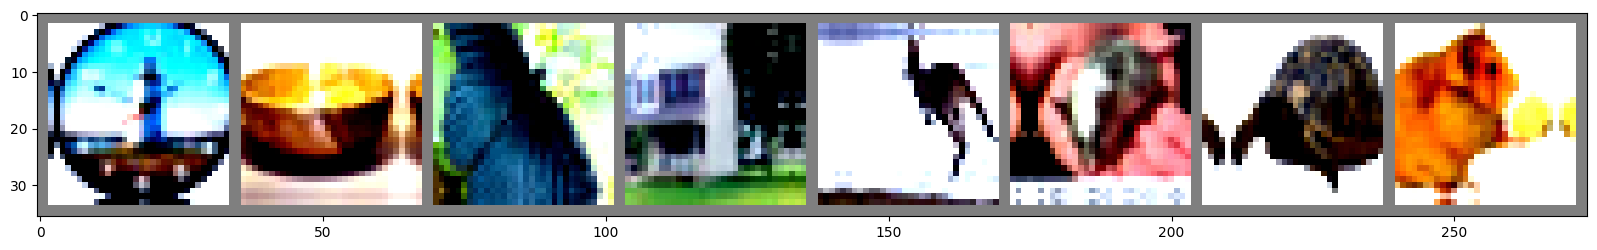

clock               bowl                butterfly           house               kangaroo            mouse               turtle              hamster             


In [ ]:
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels using loop (for multi-processing)
for images, labels in train_8_samples:
    imshow(torchvision.utils.make_grid(images))
    print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(len(labels))))  # Use len(labels) for dynamic printing
    break

### Get CUDA ready

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    device = torch.device("cpu")
print("using", device, "device")

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4070 Laptop GPU
__CUDA Device Total Memory [GB]: 8.585216
using cuda device


In [12]:
# Returns a PyTorch device object for either the GPU or the CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

# Moves PyTorch tensor to the specified device
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

# Class wrapper around a PyTorch data loader that automatically moves each batch of data to the specified device
class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device

    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data)

Ensures that data and models are always on the correct device

In [13]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


Function to calculate the accuracy of a model's predictions.

`_, predictions` is used to find the maximum value of predicted output from a model.

The code compares predicted class labels with actual labels, creating a tensor of booleans. The sum is converted to a Python integer, and the total number of predictions is calculated, wrapped in a PyTorch tensor.

In [14]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

---

### BaseModel

The `BaseModel` class inherits from `nn.Module` and provides a base for training and validating a neural network model. It includes the following methods:

- `training_step`: Takes a batch of data, performs a forward pass through the model, computes the cross-entropy loss, and returns the loss.

- `validation_step`: Takes a batch of data, performs a forward pass through the model, computes the cross-entropy loss and accuracy, and returns them in a dictionary.

- `validation_epoch_end`: Aggregates the validation losses and accuracies from all batches, computes their mean, and returns them in a dictionary.

- `epoch_end`: Prints the results at the end of each epoch.

In [15]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### ResNet Implementation

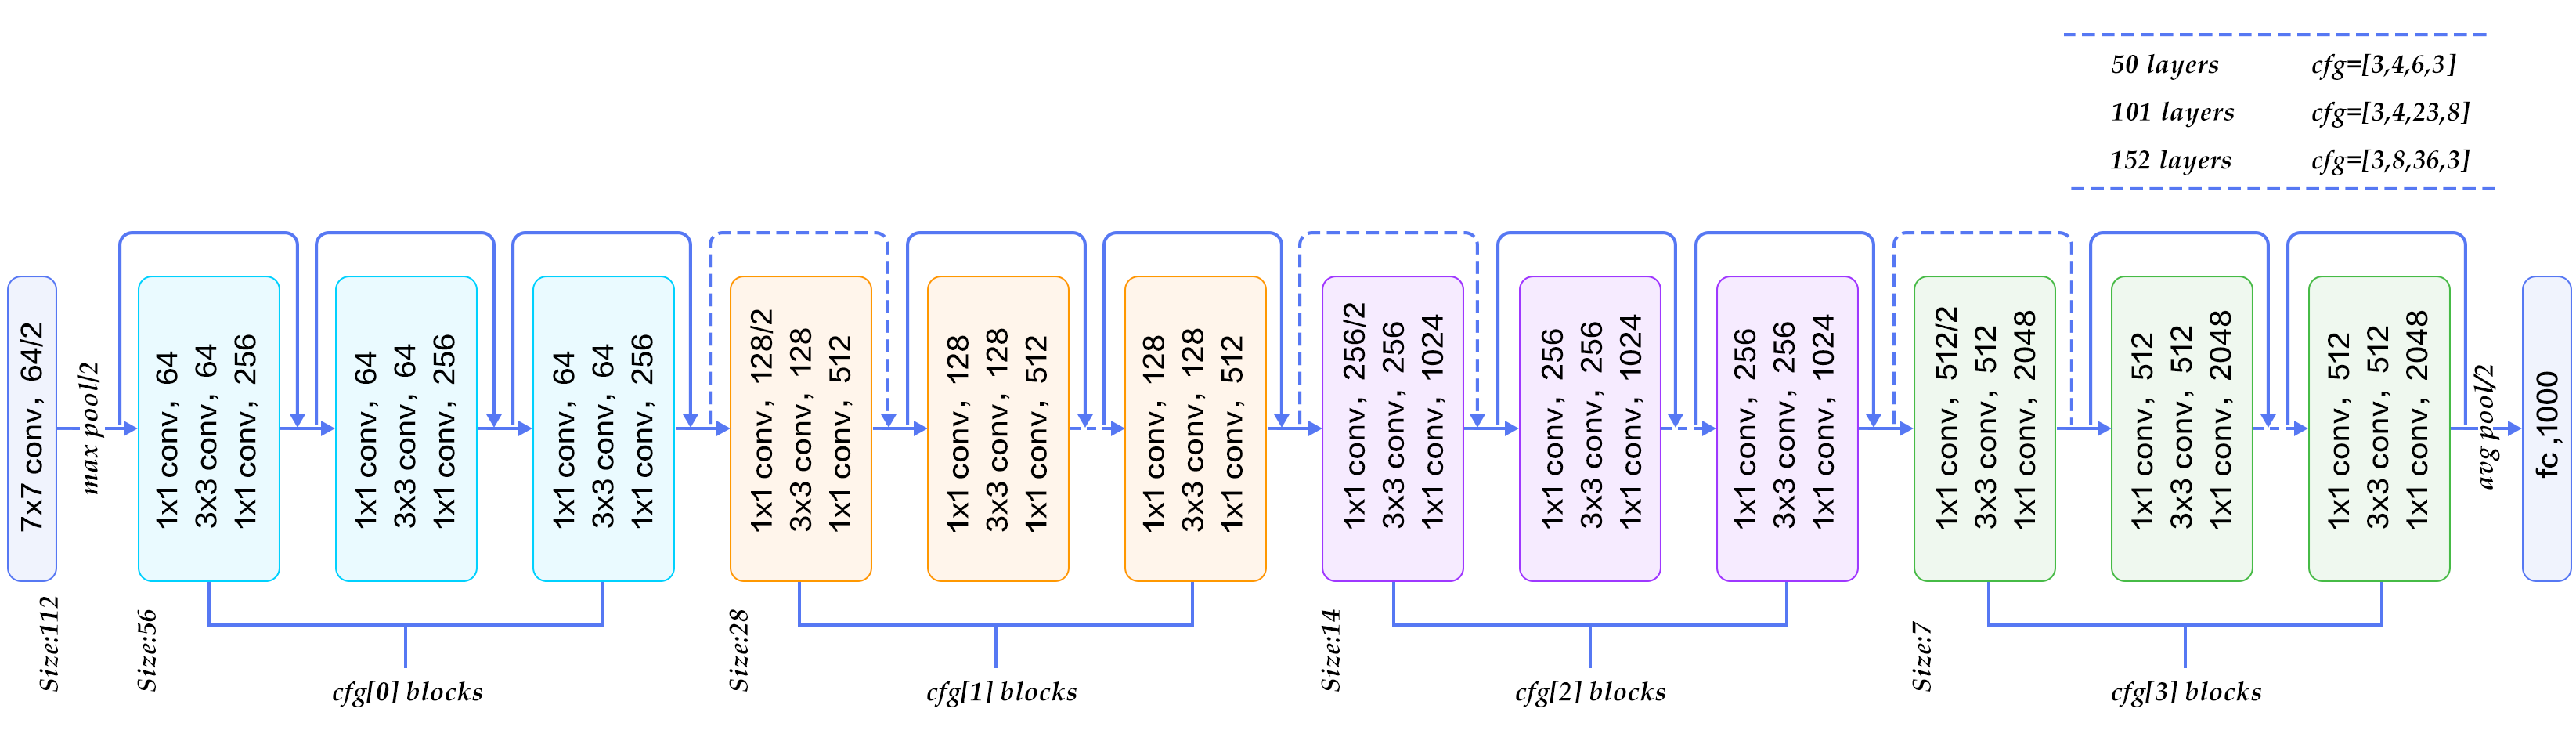
<br/>

In [16]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None

    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)

    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers

    return nn.Sequential(*layers)


class ResNet(BaseModel):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.stg1 = nn.Sequential( nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))

        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)


        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)


        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)


        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))

    def forward(self,inputs):
        out = self.stg1(inputs)

        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)

        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)

        #stage4
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)

        #Classify
        out = self.classifier(out)#100x1024

        return out

The provided code defines a ResNet model in PyTorch, including helper functions for creating convolutional blocks and shortcuts. Here's a breakdown of the code:

### Helper Functions

- **conv_shortcut(in_channel, out_channel, stride)**:
    - Creates a convolutional shortcut layer with a 1x1 convolution followed by batch normalization.
    - This is used to match the dimensions of the input and output when the number of channels changes.

- **block(in_channel, out_channel, k_size, stride, conv=False)**:
    - Creates a convolutional block consisting of two convolutional layers.
    - The first layer is a 1x1 convolution followed by batch normalization and ReLU activation.
    - The second layer is a k_size x k_size convolution followed by batch normalization.
    - If `conv` is True, the stride of the first layer is set to the provided stride value.

### ResNet Class

- **ResNet(BaseModel)**:
    - Inherits from `BaseModel` and defines the architecture of the ResNet model.
    - The model consists of four stages, each with a series of convolutional blocks and shortcuts.
    - The final stage includes an average pooling layer, a flattening layer, and a fully connected layer for classification.

#### Initialization (`__init__` method)

- **Stage 1**:
    - A convolutional layer with 64 output channels, followed by batch normalization, ReLU activation, and max pooling.

- **Stage 2**:
    - A convolutional shortcut to match dimensions.
    - A convolutional block with 64 and 256 output channels.
    - Three identity blocks with 256 output channels.

- **Stage 3**:
    - A convolutional shortcut to match dimensions.
    - A convolutional block with 128 and 512 output channels.
    - Five identity blocks with 512 output channels.

- **Stage 4**:
    - A convolutional shortcut to match dimensions.
    - A convolutional block with 256 and 1024 output channels.
    - Six identity blocks with 1024 output channels.

- **Classifier**:
    - An average pooling layer, followed by a flattening layer and a fully connected layer for classification.

#### Forward Method

- Defines the forward pass of the model.
- Passes the input through each stage and the classifier to produce the final output.

In [17]:
model = ResNet(3,100)

In [18]:
model = to_device(model, device)

# Evaluation & Fit Function for Training

In [19]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()

    history = []

    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)

    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        model.train()

        train_loss = []

        lrs = []

        for batch in train_dl:
            loss = model.training_step(batch)

            train_loss.append(loss)

            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs

        model.epoch_end(epoch,result)
        history.append(result)

    return history


# Hyperparameters

- **max_lr**: is the maximum learning rate that we set for learning rate scheduler. For the learning rate scheduler we used OneCycleLR, which sets the learning rate to a low learning rate, gradually increases it to the max learning rate then goes back to a low learning rate. <br/>
- **grad_clip**: prevents the gradients to become too large. <br/>
- **weight_decay**: essentially tries to make the model simple and helps the model generalise better.


In [21]:
epochs = 100
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

# Training

In [23]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model,
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00004, train_loss: 3.8870, val_loss: 3.9565, val_acc: 0.0865
Epoch [1], last_lr: 0.00005, train_loss: 3.2061, val_loss: 3.5899, val_acc: 0.1453
Epoch [2], last_lr: 0.00006, train_loss: 2.8865, val_loss: 3.6106, val_acc: 0.1445
Epoch [3], last_lr: 0.00008, train_loss: 2.6597, val_loss: 3.2527, val_acc: 0.2022
Epoch [4], last_lr: 0.00010, train_loss: 2.4660, val_loss: 2.9976, val_acc: 0.2577
Epoch [5], last_lr: 0.00013, train_loss: 2.3154, val_loss: 2.9252, val_acc: 0.2633
Epoch [6], last_lr: 0.00016, train_loss: 2.1781, val_loss: 2.7735, val_acc: 0.3002
Epoch [7], last_lr: 0.00020, train_loss: 2.0638, val_loss: 2.6545, val_acc: 0.3239
Epoch [8], last_lr: 0.00024, train_loss: 1.9824, val_loss: 2.5496, val_acc: 0.3394
Epoch [9], last_lr: 0.00028, train_loss: 1.9015, val_loss: 2.3063, val_acc: 0.3980
Epoch [10], last_lr: 0.00032, train_loss: 1.8448, val_loss: 2.2928, val_acc: 0.3947
Epoch [11], last_lr: 0.00037, train_loss: 1.7770, val_loss: 2.4057, val_acc: 0.3742
Ep

# Plotting

In [24]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])

def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

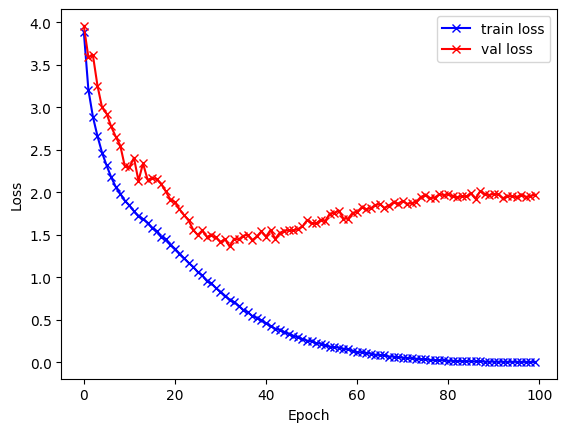

In [25]:
plot_loss(history)

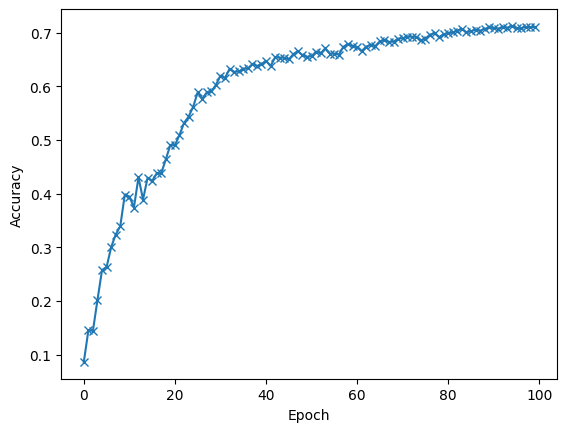

In [26]:
plot_acc(history)

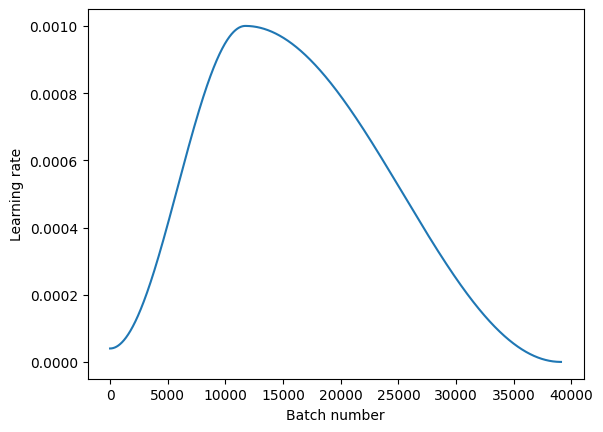

In [27]:
plot_lrs(history)

# Predictions


In [28]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5480932..2.76].


Label: mountain , Predicted: train


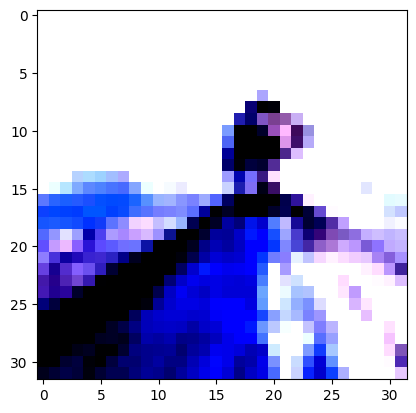

In [30]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.074609..2.326722].


Label: wardrobe , Predicted: wardrobe


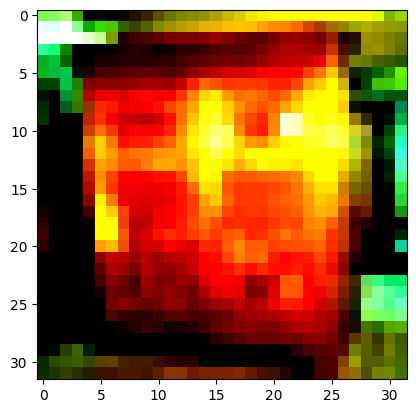

In [31]:
img, label = test_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.406119..2.76].


Label: house , Predicted: train


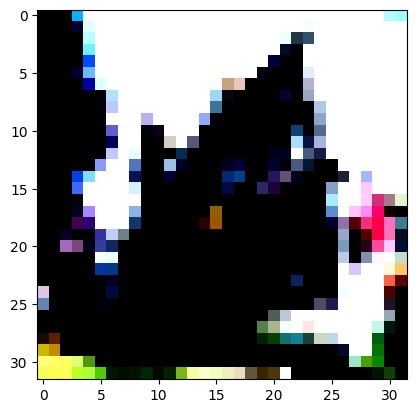

In [33]:
img, label = test_data[808]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

# Save

In [34]:
torch.save(model.state_dict(), 'cifar100-resnet-project.pth')